This notebook converts audio matrices `.npy` into hand crafted MIR features that are cocatenated together and saved to `./drumFeatures`. Output dimensions per file is (6,24). Features are:
- RMS
- Spectral Centroid
- Spectral Crest
- Spectral Flux
- Spectral Rolloff
- Zerocrossing Rate 


In [22]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

In [2]:
data_root = './drumData'

# Load the audio matrices

In [3]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.1 ms, sys: 153 ms, total: 154 ms
Wall time: 152 ms
CPU times: user 994 µs, sys: 13.5 ms, total: 14.5 ms
Wall time: 14.1 ms
CPU times: user 845 µs, sys: 72.6 ms, total: 73.4 ms
Wall time: 73.1 ms
CPU times: user 606 µs, sys: 36.3 ms, total: 36.9 ms
Wall time: 36.7 ms
CPU times: user 800 µs, sys: 5.45 ms, total: 6.25 ms
Wall time: 5.97 ms
CPU times: user 588 µs, sys: 6.1 ms, total: 6.69 ms
Wall time: 6.51 ms
CPU times: user 793 µs, sys: 21 ms, total: 21.8 ms
Wall time: 21.6 ms


In [4]:
crashes = drumSamples["crash"]
kicks = drumSamples["kick"]

# Feature Extraction Pipeline

In [5]:
# Librosa does not support computing spectral crest nor spectral flux,
# so we write our own function based on MIR assignment 2
def computeSpectralCrest(sample):
    sample_fft = librosa.core.stft(sample, hop_length=512) 
    sample_fft = np.abs(sample_fft)
    numBlocks = sample_fft.shape[1]
    spectral_crest = np.zeros((1,numBlocks))
    for i in range(numBlocks):
        blockFFT = sample_fft[:,i]
        #print("---",i,"---")
        #print("np.max(blockFFT): ", np.max(blockFFT))
        #print("np.sum(blockFFT): ", np.sum(blockFFT))
        if np.sum(blockFFT) == 0:
            spectral_crest[:,i] = 0  # Need to ask about this!!! Prevents division by zero
        else:
            spectral_crest[:,i] = np.max(blockFFT) / np.sum(blockFFT)
    return spectral_crest

def computeSpectralFlux(sample):
    sample_fft = librosa.core.stft(sample, hop_length=512) 
    sample_fft = np.abs(sample_fft)
    (blockSize, numBlocks) = sample_fft.shape
    spectral_flux = np.zeros((1,numBlocks))
    spectral_flux[0] = 0 # Set flux at 0 for very first timestep
    for i in range(1,numBlocks):
        spectral_diff = sample_fft[:,i] - sample_fft[:,i-1]
        spectral_flux[:,i] = np.sqrt(np.sum(np.square(spectral_diff))) / (blockSize) # in MATLAB version we do blockSize/2 because MATLAB does not automatically halve and discard the spectrum for us
    return spectral_flux

In [6]:
def extractFeatures(sample):
    num_features = 6 # RMS, spectral centroid, spectral crest, spectral flux, zero crossing, spectral rolloff
    num_blocks = 24 # Our samples are each 12000 samples long, so there are 24 blocks with 512 hopsize
    # TODO: create a config file that passes sr = 48000 to all processing pipelines
    sr = 48000 
    feature_matrix = np.zeros((num_features,num_blocks))
    
    # RMS
    feature_matrix[0,:] = librosa.feature.rmse(y=sample)
    
    # Spectral Centroid 
    feature_matrix[1,:] = librosa.feature.spectral_centroid(y=sample, sr=sr)
    
    # Spectral Crest 
    feature_matrix[2,:] = computeSpectralCrest(sample)
    
    # Spectral Flux 
    feature_matrix[3,:] = computeSpectralFlux(sample)
    
    # Spectral Roll-off
    feature_matrix[4,:] = librosa.feature.spectral_rolloff(sample)
    
    # Zerocrossing Rate
    feature_matrix[5,:] = librosa.feature.zero_crossing_rate(y=sample)
    
    return feature_matrix

#### Sanity check on feature extraction pipeline

In [7]:
def plotFeatureMatrix(original_sample, feature_matrix):
    (num_features, num_blocks) = feature_matrix.shape
    feature_dict = ["RMS","Spectral Centroid","Spectral Crest","Spectral Flux","Spectral Roll-off","Zerocrossing Rate"]

    plt.figure()
    plt.plot(original_sample)
    plt.title("Original Sample")

    for i in range(num_features):
        feature = feature_matrix[i,:]
        plt.figure()
        plt.plot(feature.T)  # have to transpose to correctly show data
        plt.title(feature_dict[i])

In [8]:
sample_kick = kicks[0]
sample_crash = crashes[0]

#### Testing on a kick

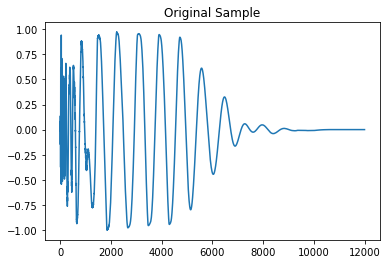

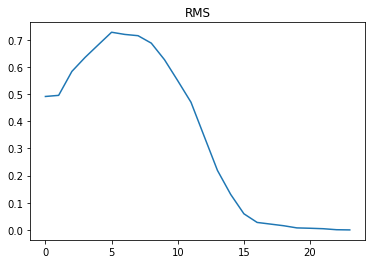

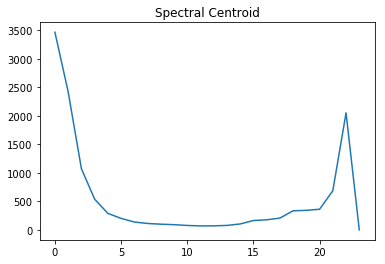

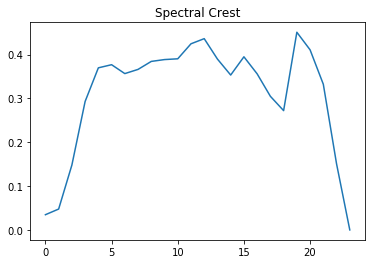

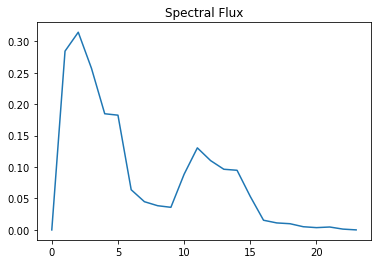

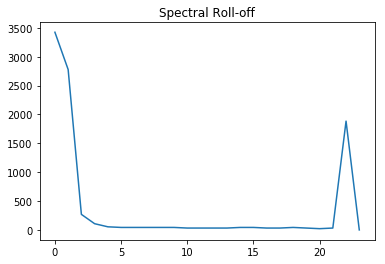

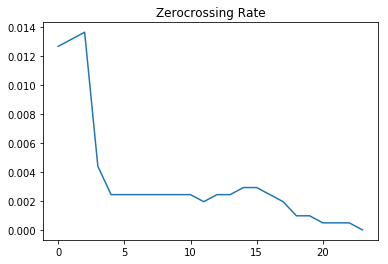

In [9]:
kick_feature_matrix = extractFeatures(sample_kick)
plotFeatureMatrix(sample_kick, kick_feature_matrix)

#### Testing on a crash

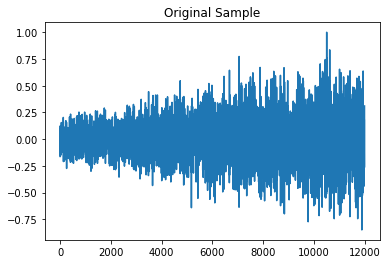

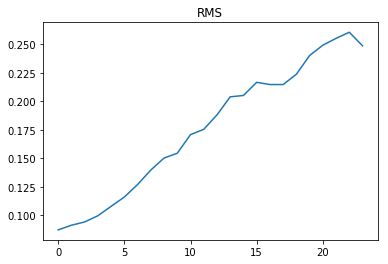

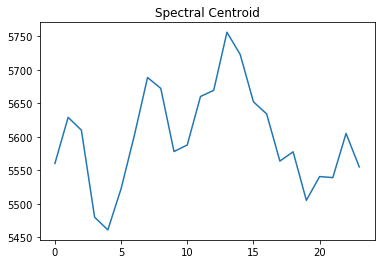

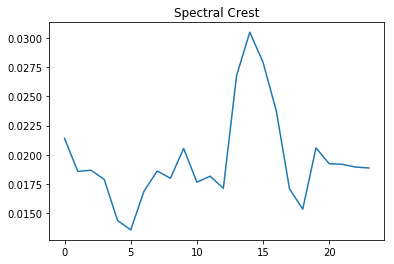

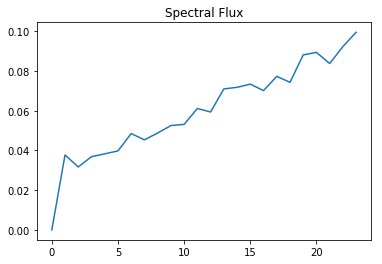

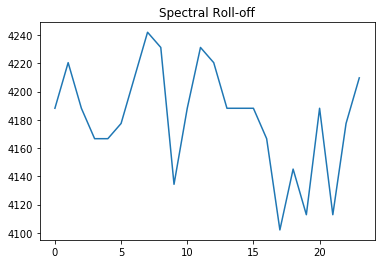

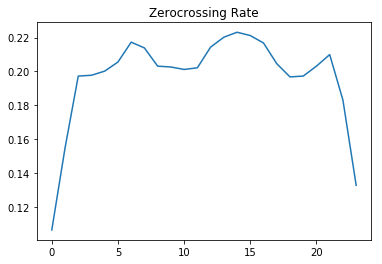

In [10]:
crash_feature_matrix = extractFeatures(sample_crash)
plotFeatureMatrix(sample_crash,crash_feature_matrix)

# Feature Normalization Pipeline

In [11]:
def aggregateFeaturesPerFile(feature_matrix):
    # We have mean and std for 6 features
    (num_features, num_blocks) = feature_matrix.shape # feature_matrix.shape=(6,24)
    num_statistics = 2
    agg_feature_matrix = np.zeros((num_features,num_statistics))
    for i in range(num_features):
        agg_feature_matrix[i,0] = np.mean(feature_matrix[i,:]) 
        agg_feature_matrix[i,1] = np.std(feature_matrix[i,:])   
    return agg_feature_matrix

def normalizeFeatureMatrix(feature_matrix):
    agg_feature_matrix = aggregateFeaturesPerFile(feature_matrix)
    (num_features, num_blocks) = feature_matrix.shape # feature_matrix.shape=(6,24)
    norm_feature_matrix = np.zeros(feature_matrix.shape) 
    for i in range(num_features):
        norm_feature_matrix[i,:] = (feature_matrix[i,:] - agg_feature_matrix[i,0]) / agg_feature_matrix[i,1]
    return norm_feature_matrix

#### Sanity check on samples

The following should all be feat_mean=0 and feat_std=1
('feat_mean: ', 7.4014868308343765e-17)
('feat_std: ', 0.99999999999999978)
('feat_mean: ', -1.8503717077085941e-17)
('feat_std: ', 1.0)
('feat_mean: ', 1.5728159515523052e-16)
('feat_std: ', 1.0)
('feat_mean: ', -1.1102230246251565e-16)
('feat_std: ', 0.99999999999999989)
('feat_mean: ', -1.8503717077085941e-17)
('feat_std: ', 0.99999999999999989)
('feat_mean: ', 0.0)
('feat_std: ', 1.0)


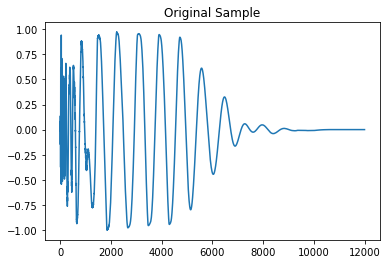

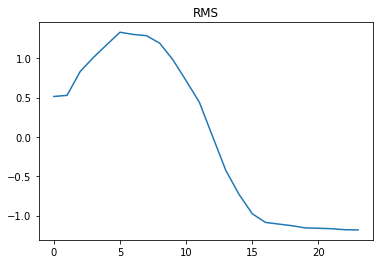

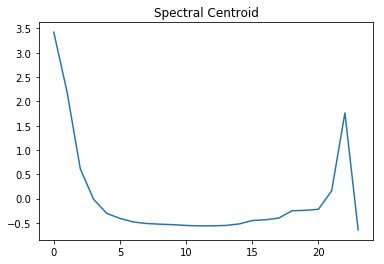

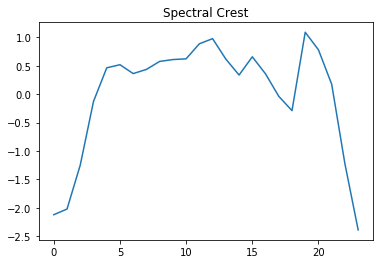

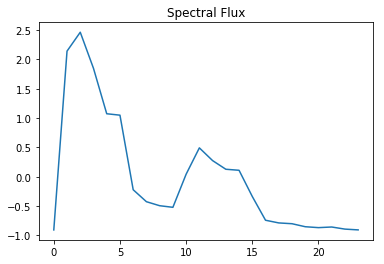

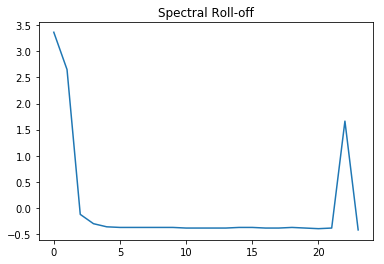

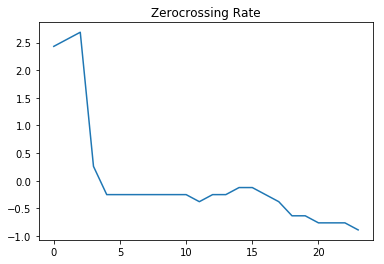

In [12]:
norm_kick_feature_matrix = normalizeFeatureMatrix(kick_feature_matrix)
plotFeatureMatrix(sample_kick, norm_kick_feature_matrix)

print("The following should all be feat_mean=0 and feat_std=1")
for i in range(6):
    print("feat_mean: ", np.mean(norm_kick_feature_matrix[i,:]))
    print("feat_std: ", np.std(norm_kick_feature_matrix[i,:]))

The following should all be feat_mean=0 and feat_std=1
('feat_mean: ', 7.4014868308343765e-17)
('feat_std: ', 0.99999999999999978)
('feat_mean: ', -1.8503717077085941e-17)
('feat_std: ', 1.0)
('feat_mean: ', 1.5728159515523052e-16)
('feat_std: ', 1.0)
('feat_mean: ', -1.1102230246251565e-16)
('feat_std: ', 0.99999999999999989)
('feat_mean: ', -1.8503717077085941e-17)
('feat_std: ', 0.99999999999999989)
('feat_mean: ', 0.0)
('feat_std: ', 1.0)


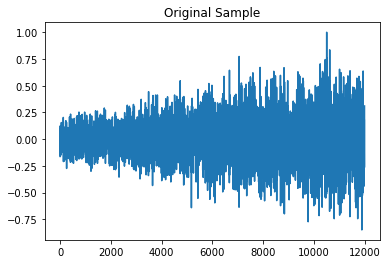

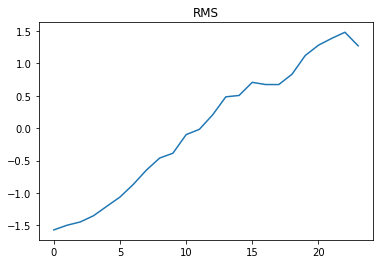

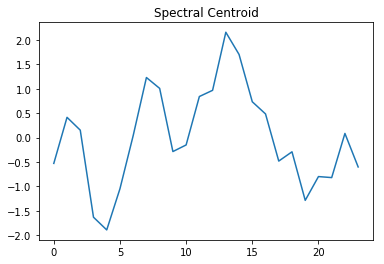

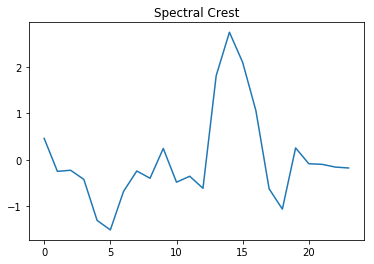

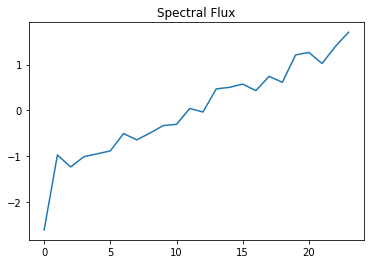

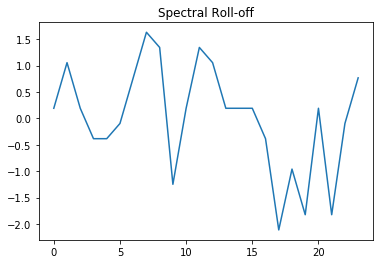

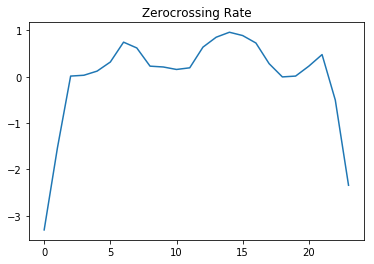

In [13]:
norm_crash_feature_matrix = normalizeFeatureMatrix(crash_feature_matrix)
plotFeatureMatrix(sample_crash, norm_crash_feature_matrix)

print("The following should all be feat_mean=0 and feat_std=1")
for i in range(6):
    print("feat_mean: ", np.mean(norm_kick_feature_matrix[i,:]))
    print("feat_std: ", np.std(norm_kick_feature_matrix[i,:]))

# Extract and normalize features for all samples

In [25]:
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
for drumName in tqdm(drumNames):
    samples = drumSamples[drumName] 
    samples_features = []
    (num_samples, sample_length) = samples.shape # e.g samples.shape=(672,12000)
    for i in tqdm(range(num_samples)):
        sample = samples[i]
        sample_feature_matrix = extractFeatures(sample)
        norm_sample_feature_matrix = normalizeFeatureMatrix(sample_feature_matrix)
        samples_features.append(norm_sample_feature_matrix)
    samples_features = np.asarray(samples_features)
    print (drumName, samples_features.shape)  
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    np.save(file_path, samples_features)



  0%|          | 0/7 [00:00<?, ?it/s]


 14%|█▍        | 1/7 [00:39<03:56, 39.50s/it]

('kick', (5158, 6, 24))




 29%|██▊       | 2/7 [00:45<02:27, 29.47s/it]

('tom', (422, 6, 24))




 43%|████▎     | 3/7 [01:11<01:53, 28.42s/it]

('snare', (2546, 6, 24))




 57%|█████▋    | 4/7 [01:23<01:10, 23.59s/it]

('clap', (1324, 6, 24))




 71%|███████▏  | 5/7 [01:25<00:33, 16.94s/it]

('hi.hat', (159, 6, 24))




 86%|████████▌ | 6/7 [01:27<00:12, 12.46s/it]

('ride', (228, 6, 24))




100%|██████████| 7/7 [01:33<00:00, 10.56s/it]

('crash', (723, 6, 24))
